# EDA of x5 dataset for Retail Hero competition

The dataset is provided by X5 Retail Group at the RetailHero hackaton hosted in winter 2019.

## Data loading

Let's download the data. We will use standard [fetch funnction](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_x5.html#x5-retailhero-uplift-modeling-dataset)

In [1]:
from sklift.datasets import fetch_x5
import pandas as pd
import numpy as np 
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.models import SoloModel
from catboost import CatBoostClassifier

pd.set_option('display.float_format', lambda x: '%.3f' % x)

dataset = fetch_x5()

dataset object is iterable dictionary-like object. 
 Let's make a brief look at what we have here.

In [2]:
dataset.keys()

dict_keys(['data', 'target', 'treatment', 'DESCR', 'feature_names', 'target_name', 'treatment_name'])

In [3]:
### data has 3 datasets
datasets_data = dataset['data']

### clients data
clients = datasets_data['clients']

### train data
train = datasets_data['train']

### purchases
purchases = datasets_data['purchases']

### Let's look at other dataset objects

### treatment feature: 
## 1 - mean there was an interaction with customer; 0 - no interaction

treatment = dataset['treatment']

### target feature

target = dataset['target']

## EDA 

### Clients 

Clients dataset consist of general information about customers.

In [4]:
clients.head()

,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,000048b7a6,2018-12-15 13:33:11,NaN,68,F
3,000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
4,00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U


In [5]:
clients.shape

(400162, 5)

Let's look at variables in clients dataset in more detail:

In [6]:
### age variable 

clients['age'].describe()

count   400162.000
mean        46.488
std         43.871
min      -7491.000
25%         34.000
50%         45.000
75%         59.000
max       1901.000
Name: age, dtype: float64

Seems like we have some outliers in data. Let's simply remove them using quantile values.

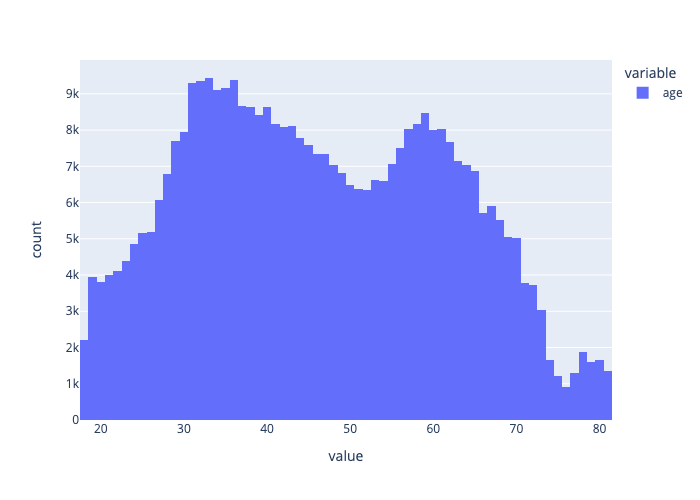

In [7]:
q_upper = np.quantile(clients['age'],0.99)
q_lower = np.quantile(clients['age'],0.01)

clients_age_cleaned = clients[(clients['age'] < q_upper) & (clients['age'] > q_lower)]['age']


fig = px.histogram(clients_age_cleaned)
fig.show('png')

In [8]:
### gender variable
clients.groupby('gender').size()

gender
F    147649
M     66807
U    185706
dtype: int64

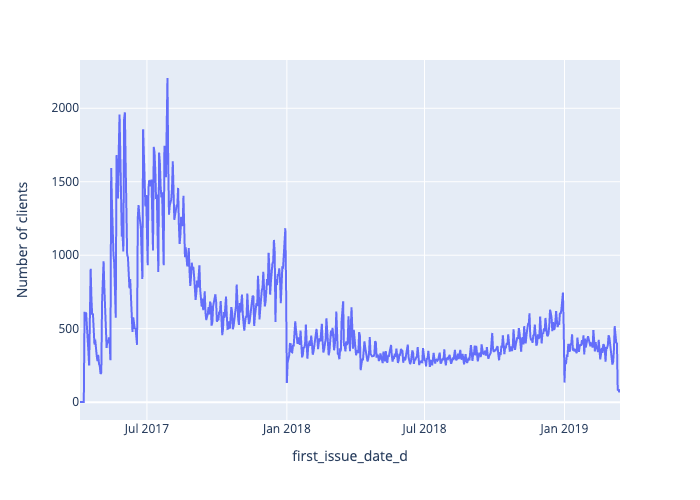

In [9]:
### first_issue_date

clients['first_issue_date'] = pd.to_datetime(clients['first_issue_date'])
clients['first_issue_date_d'] = clients['first_issue_date'].dt.date
clients_issues_dates = pd.DataFrame(clients.groupby('first_issue_date_d').size()).\
reset_index().rename(columns = {0: 'Number of clients'})

fig = px.line(clients_issues_dates, x = 'first_issue_date_d', y = 'Number of clients')
fig.show('png')

### Purchases

Purchases dataset present information about customer transactions.

In [10]:
purchases.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.000,0.000,0.000,0.000,1007.000,54a4a11a29,9a80204f78,2.000,80.000,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.000,0.000,0.000,0.000,1007.000,54a4a11a29,da89ebd374,1.000,65.000,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.000,0.000,0.000,0.000,1007.000,54a4a11a29,0a95e1151d,1.000,24.000,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.000,0.000,0.000,0.000,1007.000,54a4a11a29,4055b15e4a,2.000,50.000,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.000,0.000,0.000,0.000,1007.000,54a4a11a29,a685f1916b,1.000,22.000,NaN


In [11]:
purchases.describe()

,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,product_quantity,trn_sum_from_iss,trn_sum_from_red
count,45786568.000,45786568.000,45786568.000,45786568.000,45786568.000,45786568.000,45786568.000,3043356.000
mean,8.050,0.061,-5.313,-0.318,777.521,1.247,73.488,76.774
std,12.685,2.426,36.036,3.288,796.535,3.138,87.540,84.271
min,0.000,0.000,-5066.000,-300.000,0.000,0.000,0.000,0.000
25%,1.400,0.000,0.000,0.000,286.000,1.000,30.000,31.000
50%,3.800,0.000,0.000,0.000,539.000,1.000,51.000,55.000
75%,10.300,0.000,0.000,0.000,976.000,1.000,90.000,95.000
max,2399.000,300.000,0.000,0.000,35149.040,14941.000,35149.000,8789.000


Seems like our dataset structure is row per client/transaction_id/product_id.

### train/treatment/target dataset

Treatment and target presents only for train part of the dataset.

In [12]:
train['treatment'] = treatment
train['target'] = target

In [13]:
train_df = clients.merge(train,how = 'right', on = 'client_id')
train_df

,client_id,first_issue_date,first_redeem_date,age,gender,first_issue_date_d,treatment,target
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,2017-08-05,0,1
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,2017-04-10,1,1
2,00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U,2018-07-24,1,1
3,0001f552b0,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F,2017-06-30,1,1
4,00020e7b18,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U,2017-11-27,1,1
...,...,...,...,...,...,...,...,...
200034,fffe0abb97,2017-11-27 08:56:54,2018-02-11 09:26:08,35,F,2017-11-27,0,0
200035,fffe0ed719,2017-09-15 08:53:24,2017-12-12 14:50:12,69,U,2017-09-15,0,1
200036,fffea1204c,2018-01-31 16:59:37,2018-03-12 17:02:27,73,F,2018-01-31,0,1
200037,fffeca6d22,2017-12-28 11:56:13,NaN,77,F,2017-12-28,1,0


In [14]:
100*(pd.crosstab(train_df['treatment'],train_df['target'])/train_df.shape[0])

target,0,1
treatment,,
0,19.844,30.176
1,18.167,31.813


So as we see above treatment and control groups are almost equal and also proportion of target in both groups is almost the same.

## Data processing

Make some data processing before uplift modeling.

In [15]:
# Extracting features from client data

train_df['first_issue_time'] = \
    (pd.to_datetime(train_df['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

train_df['first_redeem_time'] = \
    (pd.to_datetime(train_df['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

train_df['issue_redeem_delay'] = train_df['first_redeem_time'] \
    - train_df['first_issue_time']


### Count number of transactions/products from purchases dataset

purchases_train = purchases.merge(train,how = 'right', on = 'client_id')
purchases_features = purchases_train.groupby('client_id')[['transaction_id','product_id']].nunique().reset_index()


In [16]:
train_df_purchases = train_df.merge(purchases_features, how = 'left', on = 'client_id')

In [17]:
train_df_purchases

,client_id,first_issue_date,first_redeem_date,age,gender,first_issue_date_d,treatment,target,first_issue_time,first_redeem_time,issue_redeem_delay,transaction_id,product_id
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,2017-08-05,0,1,1501947648,1515094207.000,13146559.000,4,46
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,2017-04-10,1,1,1491832463,1492951076.000,1118613.000,32,96
2,00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U,2018-07-24,1,1,1532449289,1536941569.000,4492280.000,18,58
3,0001f552b0,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F,2017-06-30,1,1,1498850438,1535461185.000,36610747.000,15,79
4,00020e7b18,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U,2017-11-27,1,1,1511782905,1515606605.000,3823700.000,18,175
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200034,fffe0abb97,2017-11-27 08:56:54,2018-02-11 09:26:08,35,F,2017-11-27,0,0,1511773014,1518341168.000,6568154.000,9,36
200035,fffe0ed719,2017-09-15 08:53:24,2017-12-12 14:50:12,69,U,2017-09-15,0,1,1505465604,1513090212.000,7624608.000,30,89
200036,fffea1204c,2018-01-31 16:59:37,2018-03-12 17:02:27,73,F,2018-01-31,0,1,1517417977,1520874147.000,3456170.000,17,45
200037,fffeca6d22,2017-12-28 11:56:13,NaN,77,F,2017-12-28,1,0,1514462173,NaN,NaN,16,34


### train/validation split

In [18]:
### Selected columns 

selected_features = ['age','gender','first_issue_time','first_redeem_time','issue_redeem_delay',
                     'transaction_id','product_id','treatment']
y = train_df_purchases['target']



In [19]:
X_train, X_val, y_train, y_val = train_test_split(train_df_purchases[selected_features],y,
                                                  test_size=0.3, random_state=123)

In [20]:
treatment_train = X_train['treatment']
treatment_val = X_val['treatment']

X_train = X_train.drop(columns = ['treatment'])
X_val = X_val.drop(columns = ['treatment'])

## Model

We will use simple SoloModel, for more complicated models please look at [models guide](https://www.uplift-modeling.com/en/latest/user_guide/models/index.html).

In [21]:
estimator = CatBoostClassifier(verbose=100, 
                               cat_features=['gender'],
                               random_state=42,
                               thread_count=1)

sm = SoloModel(estimator)
sm = sm.fit(X_train, y_train, treatment_train)

Learning rate set to 0.08499
0:	learn: 0.6704391	total: 195ms	remaining: 3m 15s
100:	learn: 0.5483643	total: 9.53s	remaining: 1m 24s
200:	learn: 0.5448690	total: 17.6s	remaining: 1m 10s
300:	learn: 0.5421207	total: 26.2s	remaining: 1m
400:	learn: 0.5397941	total: 33.7s	remaining: 50.3s
500:	learn: 0.5375020	total: 41.4s	remaining: 41.3s
600:	learn: 0.5353400	total: 49.5s	remaining: 32.9s
700:	learn: 0.5332216	total: 57.6s	remaining: 24.6s
800:	learn: 0.5312421	total: 1m 5s	remaining: 16.2s
900:	learn: 0.5294681	total: 1m 12s	remaining: 8.02s
999:	learn: 0.5277310	total: 1m 21s	remaining: 0us


In [22]:
## Let's make predict and calculate uplift score 
uplift_sm = sm.predict(X_val)
sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treatment_val, strategy='overall', k=0.1)

In [23]:
sm_score

0.09103971954830925

Thank you for reading! For more tutorials on uplift modeling please visit this [page](https://www.uplift-modeling.com/en/latest/tutorials.html) .